In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cd95092p because the default path (/home/jgacal/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import re
import numpy as np
import pandas as pd

In [3]:
sc = SparkContext('local[*]')
spark = SparkSession(sc)

22/02/27 00:51:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/27 00:51:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


**General instructions and tips:**
* Work with smaller subsets of data before processing the entire dataset.
* Make sure to execute the read-only cell right after the answer cell.
* Do **not** print or display large amount of results. You will get deductions if you make the browser unresponsive.
* Activate the `ExecuteTime` Jupyter extension so that the runtime is shown.
* Keep all output.

# Problem 1 [4 pts]

Create a function `mean_daily_views` that returns a Spark RDD of key-value pairs. The key corresponds to the day of the month and the value corresponds to the mean page views per day of the month for the English Wikipedia (`en.z`) article `Big_Data` (exact match). Use data from the Wikipedia page views dataset at `/mnt/localdata/public/wikipedia/pageviews` created in the first 8 months of 2020. You will need the files whose filenames end with `views-ge-5.bz2`. The data format of each file is described in the first few lines of each file.
The encoding of the bzipped text files is `latin-1`. 

The output of the cell after the answer cell should be the same as below. Your solution should be a single Spark RDD method call chain. Runtime of the final code is less than 1h 15m.

<img src="pageviews.png" style="width: 16em" />

In [4]:
import glob

gstring = glob.glob('/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-**-views-ge-5.bz2')
gstring

['/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-08-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-06-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-07-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-03-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-04-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-05-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-02-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-01-views-ge-5.bz2']

In [5]:
sc.textFile(gstring[0]).take(1)

['# Wikimedia page request counts for year 2020 month 07']

In [6]:
li = []
for i, g in enumerate(gstring):
    out = sc.textFile(g).take(1)
    print(i, out)
    
    if re.search(r'.2020 month 0[1-8]', out[0]):
        li.append((i, out))
    
li

0 ['# Wikimedia page request counts for year 2020 month 07']
1 ['# Wikimedia page request counts for year 2020 month 05']
2 ['# Wikimedia page request counts for year 2020 month 06']
3 ['# Wikimedia page request counts for year 2020 month 02']
4 ['# Wikimedia page request counts for year 2020 month 03']
5 ['# Wikimedia page request counts for year 2020 month 04']
6 ['# Wikimedia page request counts for year 2020 month 01']
7 ['# Wikimedia page request counts for year 2019 month 12']


[(0, ['# Wikimedia page request counts for year 2020 month 07']),
 (1, ['# Wikimedia page request counts for year 2020 month 05']),
 (2, ['# Wikimedia page request counts for year 2020 month 06']),
 (3, ['# Wikimedia page request counts for year 2020 month 02']),
 (4, ['# Wikimedia page request counts for year 2020 month 03']),
 (5, ['# Wikimedia page request counts for year 2020 month 04']),
 (6, ['# Wikimedia page request counts for year 2020 month 01'])]

In [7]:
scope_files = [gstring[x] for x in [y[0] for y in li]]
scope_files

['/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-08-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-06-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-07-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-03-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-04-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-05-views-ge-5.bz2',
 '/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-02-views-ge-5.bz2']

In [8]:
scope_files[3]

'/mnt/localdata/public/wikipedia/pageviews/pagecounts-2020-03-views-ge-5.bz2'

In [9]:
sc.textFile(scope_files[3]).take(1)

['# Wikimedia page request counts for year 2020 month 02']

In [10]:
(sc.textFile(scope_files[3])
 .map(lambda x: x if re.search(r'^en.z Big_Data\b', x) else '')
 .filter(lambda x: x != '')
 .take(34))

['en.z Big_Data 959 AC1E1F1H1I1J2L2M1O1P1Q3T2X3,BA5B1C4D2F1G1H1J3K2L2M1N1O1P2Q2S3T2,CA1D1F2G1H1J3L1M3N1O1Q2R1T2V2W1X1,DB1C1E1F1K1O4P1Q2R1S2U4V1W4X2,EA1B2D1E1F1G1H3I1L2M4N1Q3R2U1V2X2,FA1B2D2E13F12G1K1L2O1R1S2T1U2,GB1C1D1E1F3G1H3J1L1N1P1Q2V2X1,HD1F2H5I1K2L2Q4R7S3U3V2W2,IA2C1D5E1F1H2I1J2L1M1N1O1P2Q5R4S1T7U19V3W3X4,JF1I1L1M2O4Q2S3U5V13W3X5,KA1C3E1G1H3I1K1L1O3P1Q4R1S3T1U1V1W1,LA1D2E1F2G2H1I3J3L2N4O3Q1R2S1T1U3V1W1,MA1B1C1D1E3F1I2K1N2O3Q2S2V1W7X119,NE1F1G1I2L1O1R1S2T1W2X2,OC1H1J1N3P1R2U2V1,PA3B1D1F3H1J1K1M1N2O2Q2R1S2T2U1W1,QC1D3E1F1G1J1K1L1M1O1Q1R1T1U1V2W3X1,RC1D1G2H1I1K2M2O4P1Q2R2S3T3U1V2X1,SB2C1D2F1G3H3L1M2N1O4P1Q1R2S2U2V1W2,TA1E2F1J2K2L1O2P3S1T1U2,UA1B1I1K1L1M2N1Q3U2V3W1X1,VB1D1E2F1H2K2L1M1O1Q1R1W2,WB1D1E2J1K1L1N1O1P1R3U1V4W2,XC2E1F1I3J1K1L1O1S1T1V1X1,YB2C3E1G2I10J1K1M3P1Q1R3T2U2V4X1,ZB1F2G1K2O5P7R2S1U2V1X2,[B1C1E2H1I2J2N1O1P1Q2R1S2T5U2V2,\\A1C2D2E1F2J1K1L1M1Q3S2T1U1V1X1,]C2E1G3H1J2K2L1O2R1S2U1X3,^A3B3D3E1F1H1I1K2L1M2N2P3Q3R1S1U3V2W1,_A1C2D4E2H1I2J1K1M3O1P3Q1R1S3U1W3,']

In [11]:
sc.textFile(scope_files[3]).count()

76122552

In [12]:
# (
#     sc.wholeTextFiles(gstring)
#     .mapValues(lambda x: x if re.search(r'^.+ 2020 month 0[1-8]') else '')
#     .mapValues(lambda x: x)
# )

In [13]:
import re
def mean_daily_views():
    return (sc.textFile('/mnt/localdata/public/wikipedia/pageviews/'
                        'pagecounts-2020-0?-views-ge-5.bz2').
            filter(lambda x: x.startswith('en.z Big_Data ')).
            map(lambda x: x.split()[3:][0]).
            flatMap(lambda x: x.split(',')[:-1]).
            map(lambda x: (ord(x[0])-64, x[1:])).
            mapValues(lambda x: sum(map(int, re.findall('\d+', x)))).
            mapValues(lambda x: (x,1)).
            reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).
            mapValues(lambda x: x[0] / x[1]))

In [14]:
sorted(mean_daily_views().collect())

[(1, 21.5),
 (2, 26.625),
 (3, 25.0),
 (4, 20.875),
 (5, 79.25),
 (6, 92.25),
 (7, 29.375),
 (8, 22.875),
 (9, 27.125),
 (10, 22.375),
 (11, 23.875),
 (12, 23.25),
 (13, 37.375),
 (14, 21.375),
 (15, 23.125),
 (16, 23.25),
 (17, 24.0),
 (18, 22.0),
 (19, 22.625),
 (20, 22.625),
 (21, 24.0),
 (22, 23.5),
 (23, 22.0),
 (24, 21.125),
 (25, 28.5),
 (26, 22.625),
 (27, 26.75),
 (28, 27.5),
 (29, 28.125),
 (30, 24.285714285714285),
 (31, 32.6)]

# Problem 2 [3 pts]

Create a function `cvr` that returns a Spark dataframe with columns `ngram` corresponding to a 1-gram and `count_volume_ratio` corresponding to the ratio of the count and volume. Consider only [Google Books](http://storage.googleapis.com/books/ngrams/books/datasetsv2.html) English 1-grams, found at `/mnt/localdata/public/ngrams`, that starts with a letter and appeared in the year 2000. Sort by decreasing `count_volume_ratio` and return only the top 10. The output of the cell after the answer cell should be the same as below. Your solution should be a single Spark DataFrame method call chain. Runtime of the final code is less than 25 minutes.

<img src="cvr.png" style="width: 15em" />

In [15]:
from pyspark.sql import functions as F
from pyspark.sql.functions import desc
from pyspark.sql.types import DecimalType

In [17]:
# (spark.read.csv('/mnt/localdata/public/ngrams/'
#                 'googlebooks-eng-all-1gram-20120701-[a-z]', sep='\t')
#  .filter()
#  .show()
# )

In [18]:
def cvr():
    return (spark.read.csv('/mnt/localdata/public/ngrams/'
                           'googlebooks-eng-all-1gram-20120701-[a-z]',
                           sep='\t')
            .filter(F.col('_c1') == '2000')
            .withColumn('ngram', F.col('_c0').cast('string'))
            .withColumn('_c2', F.col('_c2').cast(DecimalType(38,6)))
            .withColumn('_c3', F.col('_c3').cast(DecimalType(38,6)))
            .groupby('ngram').sum()
            .withColumn('count_volume_ratio',
                        (F.col("sum(_c2)") / F.col("sum(_c3)")))
            .orderBy(desc('count_volume_ratio'))
            .drop('sum(_c2)','sum(_c3)')
            .limit(10)
           )


In [19]:
cvr().toPandas()

,ngram,count_volume_ratio
0,việc,6089.000000
1,the,5020.630577
2,the_DET,5018.625248
3,oCk,3487.000000
4,không,3387.000000
5,of,3158.661189
6,of_ADP,3155.379170
7,○_NUM,2997.125000
8,hành,2661.000000
9,CLIL,2602.000000


# Problem 3 [3 pts]

Create a function `comments_by_account_creation` that returns a SQL statement to process the registered Spark data frame `comments` into a data frame with columns `account created` and `comments`. The column `account created` corresponds to the year-month, in Philippine Standard Time, the comment author was created and `comments` corresponds to the number of comments authored by users created that year-month. Sort in reverse chronological order of `account created`. Return the most recent 12 months only. The output of the cell after the answer cell should be the same as below. Runtime of the final code is about an hour.

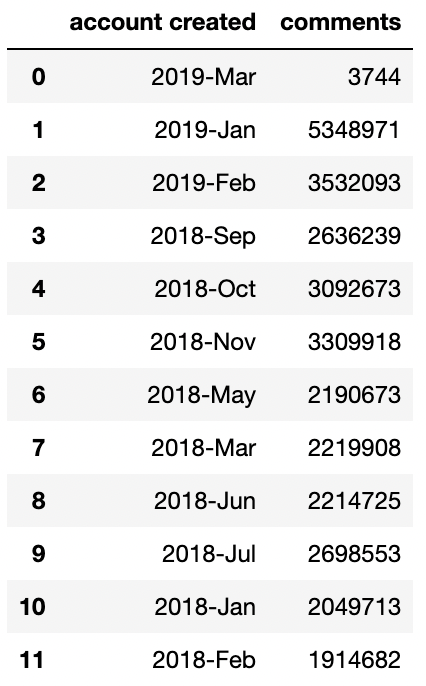

In [20]:
%%bash --out output
head --lines=100 /mnt/localdata/public/reddit/comments/RC_2019-02-02

In [21]:
sampleRDD = sc.parallelize(output.split('\n'))
sample = spark.read.json(sampleRDD)

In [22]:
sample.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_created_utc: long (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- a: string (nullable = true)
 |    |    |-- e: string (nullable = true)
 |    |    |-- t: string (nullable = true)
 |    |    |-- u: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |

In [23]:
sample.createOrReplaceTempView('comments_sample')
query = """
select * from comments_sample LIMIT 10
"""
spark.sql(query).toPandas()

22/02/27 11:43:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,quarantined,removal_reason,retrieved_on,score,send_replies,stickied,subreddit,subreddit_id,subreddit_name_prefixed,subreddit_type
0,AutoModerator,None,1325741068,None,None,[],None,None,None,text,...,False,None,1553412042,1,False,True,PoliticalVideo,t5_3arin,r/PoliticalVideo,public
1,sfnxboy,None,1542338091,None,None,[],None,None,None,text,...,True,None,1553412042,1,True,False,4chan,t5_2qh4w,r/4chan,public
2,sonicandfffan,None,1325111878,None,None,[],None,None,None,text,...,False,None,1553412042,-21,True,False,nottheonion,t5_2qnts,r/nottheonion,public
3,HyalopterousLemure,None,1506515854,None,None,[],None,None,None,text,...,False,None,1553412042,20,True,False,mtgfinance,t5_2vv1m,r/mtgfinance,public
4,Raptoot83,None,1498319573,None,None,[],None,None,None,text,...,False,None,1553412042,2,True,False,gaming,t5_2qh03,r/gaming,public
5,james_bena,None,1537061635,None,None,[],None,None,None,text,...,False,None,1553412042,1,True,False,JuiceWRLD,t5_gm2ug,r/JuiceWRLD,public
6,Blaskowici,None,1546014307,,green tier2,"[(None, text, +18 Karma, None)]",None,+18 Karma,dark,richtext,...,False,None,1553412042,1,True,False,Market76,t5_n9nn1,r/Market76,public
7,NullIsUndefined,None,1485232617,None,None,[],None,None,None,text,...,False,None,1553412042,9,True,False,Libertarian,t5_2qh63,r/Libertarian,public
8,genjipress,None,1365871750,,,[],4cc838b8-3159-11e1-83e4-12313d18ad57,return self,dark,text,...,False,None,1553412042,3,True,False,Python,t5_2qh0y,r/Python,public
9,SaneManiac741,None,1506122433,None,None,[],None,None,None,text,...,False,None,1553412042,1,True,False,PrequelMemes,t5_3i60n,r/PrequelMemes,public


In [24]:
statement = """

SELECT 
    from_unixtime(author_created_utc) as author_created_utc,
    from_utc_timestamp(from_unixtime(author_created_utc), 'GMT+8') as author_created_gmt8,
    from_unixtime(created_utc) as created_utc,
    from_utc_timestamp(from_unixtime(created_utc), 'GMT+8') as created_utc_gmt8
FROM comments_sample
LIMIT 10

"""
spark.sql(statement).show()

+-------------------+-------------------+-------------------+-------------------+
| author_created_utc|author_created_gmt8|        created_utc|   created_utc_gmt8|
+-------------------+-------------------+-------------------+-------------------+
|2012-01-05 13:24:28|2012-01-05 21:24:28|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2018-11-16 11:14:51|2018-11-16 19:14:51|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2011-12-29 06:37:58|2011-12-29 14:37:58|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2017-09-27 20:37:34|2017-09-28 04:37:34|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2017-06-24 23:52:53|2017-06-25 07:52:53|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2018-09-16 09:33:55|2018-09-16 17:33:55|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2018-12-29 00:25:07|2018-12-29 08:25:07|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2017-01-24 12:36:57|2017-01-24 20:36:57|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2013-04-14 00:49:10|2013-04-14 08:49:10|2019-02-02 08:00:00|2019-02-02 16:00:00|
|2017-09-23 07:2

In [25]:
statement = """
SELECT 
    date_format(author_created_gmt8, 'yyyy-MMM') as author_created_gmt8,
    date_format(created_utc_gmt8, 'yyyy-MMM') as created_utc_gmt8,
    date_format(author_created_utc, 'yyyy-MMM') as author_created_utc,
    date_format(created_utc, 'yyyy-MMM') as create_utc
FROM
    (SELECT 
        from_unixtime(author_created_utc) as author_created_utc,
        from_utc_timestamp(from_unixtime(author_created_utc), 'GMT+8') as author_created_gmt8,
        from_unixtime(created_utc) as created_utc,
        from_utc_timestamp(from_unixtime(created_utc), 'GMT+8') as created_utc_gmt8
    FROM comments_sample
    LIMIT 10
    )
WHERE author_created_utc IS NOT NULL

LIMIT 10
"""
spark.sql(statement).show()

+-------------------+----------------+------------------+----------+
|author_created_gmt8|created_utc_gmt8|author_created_utc|create_utc|
+-------------------+----------------+------------------+----------+
|           2012-Jan|        2019-Feb|          2012-Jan|  2019-Feb|
|           2018-Nov|        2019-Feb|          2018-Nov|  2019-Feb|
|           2011-Dec|        2019-Feb|          2011-Dec|  2019-Feb|
|           2017-Sep|        2019-Feb|          2017-Sep|  2019-Feb|
|           2017-Jun|        2019-Feb|          2017-Jun|  2019-Feb|
|           2018-Sep|        2019-Feb|          2018-Sep|  2019-Feb|
|           2018-Dec|        2019-Feb|          2018-Dec|  2019-Feb|
|           2017-Jan|        2019-Feb|          2017-Jan|  2019-Feb|
|           2013-Apr|        2019-Feb|          2013-Apr|  2019-Feb|
|           2017-Sep|        2019-Feb|          2017-Sep|  2019-Feb|
+-------------------+----------------+------------------+----------+



In [26]:
statement = """

SELECT author_created_utc as `account created`, COUNT(*) as comments
FROM
    (
    SELECT 
        date_format(author_created_gmt8, 'yyyy-MMM') as author_created_gmt8,
        date_format(created_utc_gmt8, 'yyyy-MMM') as created_utc_gmt8,
        date_format(author_created_utc, 'yyyy-MMM') as author_created_utc,
        date_format(created_utc, 'yyyy-MMM') as create_utc
    FROM
        (
        SELECT 
            from_unixtime(author_created_utc) as author_created_utc,
            from_utc_timestamp(from_unixtime(author_created_utc), 'GMT+8') as author_created_gmt8,
            from_unixtime(created_utc) as created_utc,
            from_utc_timestamp(from_unixtime(created_utc), 'GMT+8') as created_utc_gmt8
        FROM comments_sample
        LIMIT 10
        )
    WHERE author_created_utc IS NOT NULL

    LIMIT 10
    )
GROUP BY 1
ORDER BY 1 DESC
LIMIT 12
    
"""
spark.sql(statement).show()

+---------------+--------+
|account created|comments|
+---------------+--------+
|       2018-Sep|       1|
|       2018-Nov|       1|
|       2018-Dec|       1|
|       2017-Sep|       2|
|       2017-Jun|       1|
|       2017-Jan|       1|
|       2013-Apr|       1|
|       2012-Jan|       1|
|       2011-Dec|       1|
+---------------+--------+



In [27]:
def comments_by_account_creation():
    statement = """
    
    SELECT author_created_utc as `account created`, COUNT(*) as comments
    FROM
        (
        SELECT 
            date_format(author_created_gmt8, 'yyyy-MMM') as author_created_gmt8,
            date_format(created_utc_gmt8, 'yyyy-MMM') as created_utc_gmt8,
            date_format(author_created_utc, 'yyyy-MMM') as author_created_utc,
            date_format(created_utc, 'yyyy-MMM') as create_utc
        FROM
            (
            SELECT 
                from_unixtime(author_created_utc) as author_created_utc,
                from_utc_timestamp(from_unixtime(author_created_utc), 'GMT+8') as author_created_gmt8,
                from_unixtime(created_utc) as created_utc,
                from_utc_timestamp(from_unixtime(created_utc), 'GMT+8') as created_utc_gmt8
            FROM comments

            )
        WHERE author_created_utc IS NOT NULL


        )
    GROUP BY 1
    ORDER BY 1 DESC
    LIMIT 12

    """
    return statement

In [28]:
(spark.read.json('/mnt/localdata/public/reddit/comments/RC_2019-02-??')
 .createOrReplaceTempView('comments'))
spark.sql(comments_by_account_creation()).toPandas()

,account created,comments
0,2019-Mar,3744
1,2019-Jan,5348971
2,2019-Feb,3532093
3,2018-Sep,2636239
4,2018-Oct,3092673
5,2018-Nov,3309918
6,2018-May,2190673
7,2018-Mar,2219908
8,2018-Jun,2214725
9,2018-Jul,2698553
